# Кластеризация текстов
Используется встроенный набор данных

In [1]:
import sklearn.datasets
all_data = sklearn.datasets.fetch_20newsgroups(subset = 'all')
print(len(all_data.filenames))

18846


Имена категорий (их 20)

In [2]:
print(all_data.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


## Выделение обучающей и тестовой выборок
Для кластеризации это не нужно, но данные размечены и их можно использовать для построения моделей классификации

Используется параметр subset:

In [3]:
train_data = sklearn.datasets.fetch_20newsgroups(subset = 'train')
print(len(train_data.filenames))

11314


In [4]:
test_data = sklearn.datasets.fetch_20newsgroups(subset = 'test')
print(len(test_data.filenames))

7532


Используем несколько категорий

In [5]:
groups = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'comp.windows.x', 'sci.space']

train_data = sklearn.datasets.fetch_20newsgroups(subset = 'train', categories = groups)
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset = 'test', categories = groups)
print(len(test_data.filenames))

3529
2349


Метки классов в размеченных данных:

In [6]:
labels = train_data.target
labels

array([5, 3, 1, ..., 2, 3, 4])

Создадим свой класс для стемминга и векторизации

Если есть сложности с ООП на Python - см. комментарии

In [7]:
import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfVectorizer
# стемминг + TF_IDF векторизация в одном классе
class StemmedTfidfVectorizer(TfidfVectorizer):
# переопределение наследованного метода
    def build_analyzer(self):
        # метод super для обращения к методу родительского класса
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        # стемминг текста
        # analyzer(doc) выделяет пос-ть слов-признаков из doc
        # к каждому слову применяется стемминг
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))


Векторизация = обучение модели-векторизатора и преобразование исходных данных

In [8]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5, stop_words='english', decode_error='ignore')

# обучение и преобразование
vectorized = vectorizer.fit_transform(train_data.data)
num_samples, num_features = vectorized.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))

#samples: 3529, #features: 4712


Кластеризация без выбора оптимального числа классов

In [9]:
#кластеризация по методу k means
num_clusters = 50
from sklearn.cluster import KMeans
# кластеризатор
km = KMeans(n_clusters=num_clusters, n_init=1, verbose=1, random_state=3)
clustered = km.fit(vectorized)# обучение
# метки сообщений по кластерам
print("km.labels_=%s" % km.labels_)

Initialization complete
Iteration 0, inertia 5668.2176871419515.
Iteration 1, inertia 3166.8781058415925.
Iteration 2, inertia 3132.141380733978.
Iteration 3, inertia 3117.1024634663454.
Iteration 4, inertia 3108.818672519524.
Iteration 5, inertia 3104.351257977539.
Iteration 6, inertia 3100.911199069322.
Iteration 7, inertia 3098.5884575936707.
Iteration 8, inertia 3096.7796420756845.
Iteration 9, inertia 3096.00724812151.
Iteration 10, inertia 3095.616810617797.
Iteration 11, inertia 3095.2431406969886.
Iteration 12, inertia 3094.9055755323893.
Iteration 13, inertia 3094.762653418838.
Iteration 14, inertia 3094.719805116146.
Converged at iteration 14: strict convergence.
km.labels_=[38 27 31 ... 23 41 46]


### Проверка

In [10]:
# все отобранные документы попали в кластеры?
print("km.labels_.shape=%s" % km.labels_.shape)

km.labels_.shape=3529


In [11]:
# центроиды кластеров
print("km.centers_=%s" % km.cluster_centers_)

km.centers_=[[0.00672873 0.00204574 0.         ... 0.         0.         0.        ]
 [0.00511381 0.00012125 0.01078844 ... 0.00015004 0.         0.        ]
 [0.00173207 0.         0.         ... 0.00283602 0.         0.        ]
 ...
 [0.00134816 0.         0.         ... 0.         0.         0.        ]
 [0.         0.01367382 0.         ... 0.         0.         0.        ]
 [0.00111957 0.         0.         ... 0.         0.         0.        ]]


**Вспомним исходную задачу - определим кластер для нового документа**

In [12]:
new_post = "Disk drive problems. Hi, I have a problem with my hard disk. After 10 years it is working terrible. I tried to format it, but I can't."

# векторизация и прогноз
new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]
# какой кластер?
print('predict_cluster_label: ', new_post_label)

predict_cluster_label:  5


### Новые задачи для выбранного кластера
Какие документы в этом кластере?

Какое расстояние до нового документа?

In [13]:
# индексы документов в выбранном кластере
similar_indices = (km.labels_ == new_post_label).nonzero()[0]


import scipy as sp
# список документов и расстояний
similar = []
for i in similar_indices:
    dist = sp.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))

similar = sorted(similar)
print("Count similar: %i" % len(similar))


Count similar: 45


### Выбор документов в кластере
Возьмем ближайший, 5-й и средний по степени близости (расстоянию)

In [14]:
show_at_1 = similar[0]
show_at_2 = similar[int(len(similar) / 10)]
show_at_3 = similar[int(len(similar) / 2)]


In [15]:
print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)


=== #1 ===
(1.0828009833518932, "From: rogntorb@idt.unit.no (Torbj|rn Rognes)\nSubject: Adding int. hard disk drive to IIcx\nKeywords: Mac IIcx, internal, hard disk drive, SCSI\nReply-To: rogntorb@idt.unit.no (Torbj|rn Rognes)\nOrganization: Div. of CS & Telematics, Norwegian Institute of Technology\nLines: 32\n\nI haven't seen much info about how to add an extra internal disk to a\nmac. We would like to try it, and I wonder if someone had some good\nadvice.\n\nWe have a Mac IIcx with the original internal Quantum 40MB hard disk,\nand an unusable floppy drive. We also have a new spare Connor 40MB\ndisk which we would like to use. The idea is to replace the broken\nfloppy drive with the new hard disk, but there seems to be some\nproblems:\n\nThe internal SCSI cable and power cable inside the cx has only\nconnectors for one single hard disk drive.\n\nIf I made a ribbon cable and a power cable with three connectors each\n(1 for motherboard, 1 for each of the 2 disks), would it work?\n\nIs

### Дополнительный анализ
Распределение расстояния от нового документа до элементов кластера

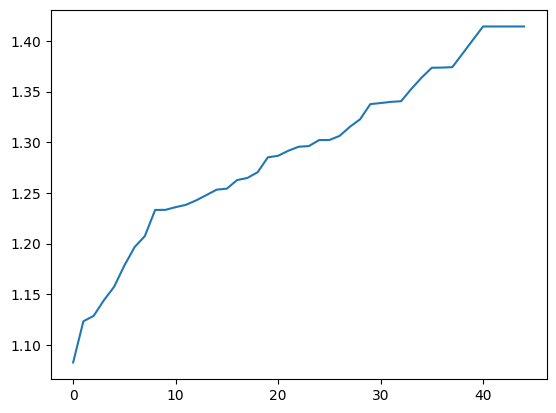

In [16]:
import matplotlib.pyplot as plt
plt.plot([x[0] for x in similar])

### Вывод
Можно было взять из первой тройки:)